In [1]:
#Импорт необходимых библиотек
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [3]:
dataset_path = ('../DataSets/lego_minifigures')

df_index = pd.read_csv(os.path.join(dataset_path, 'index.csv'))
df_metadata = pd.read_csv(os.path.join(dataset_path, 'metadata.csv'))
df = pd.merge(df_index, df_metadata[['class_id', 'minifigure_name']], on='class_id')

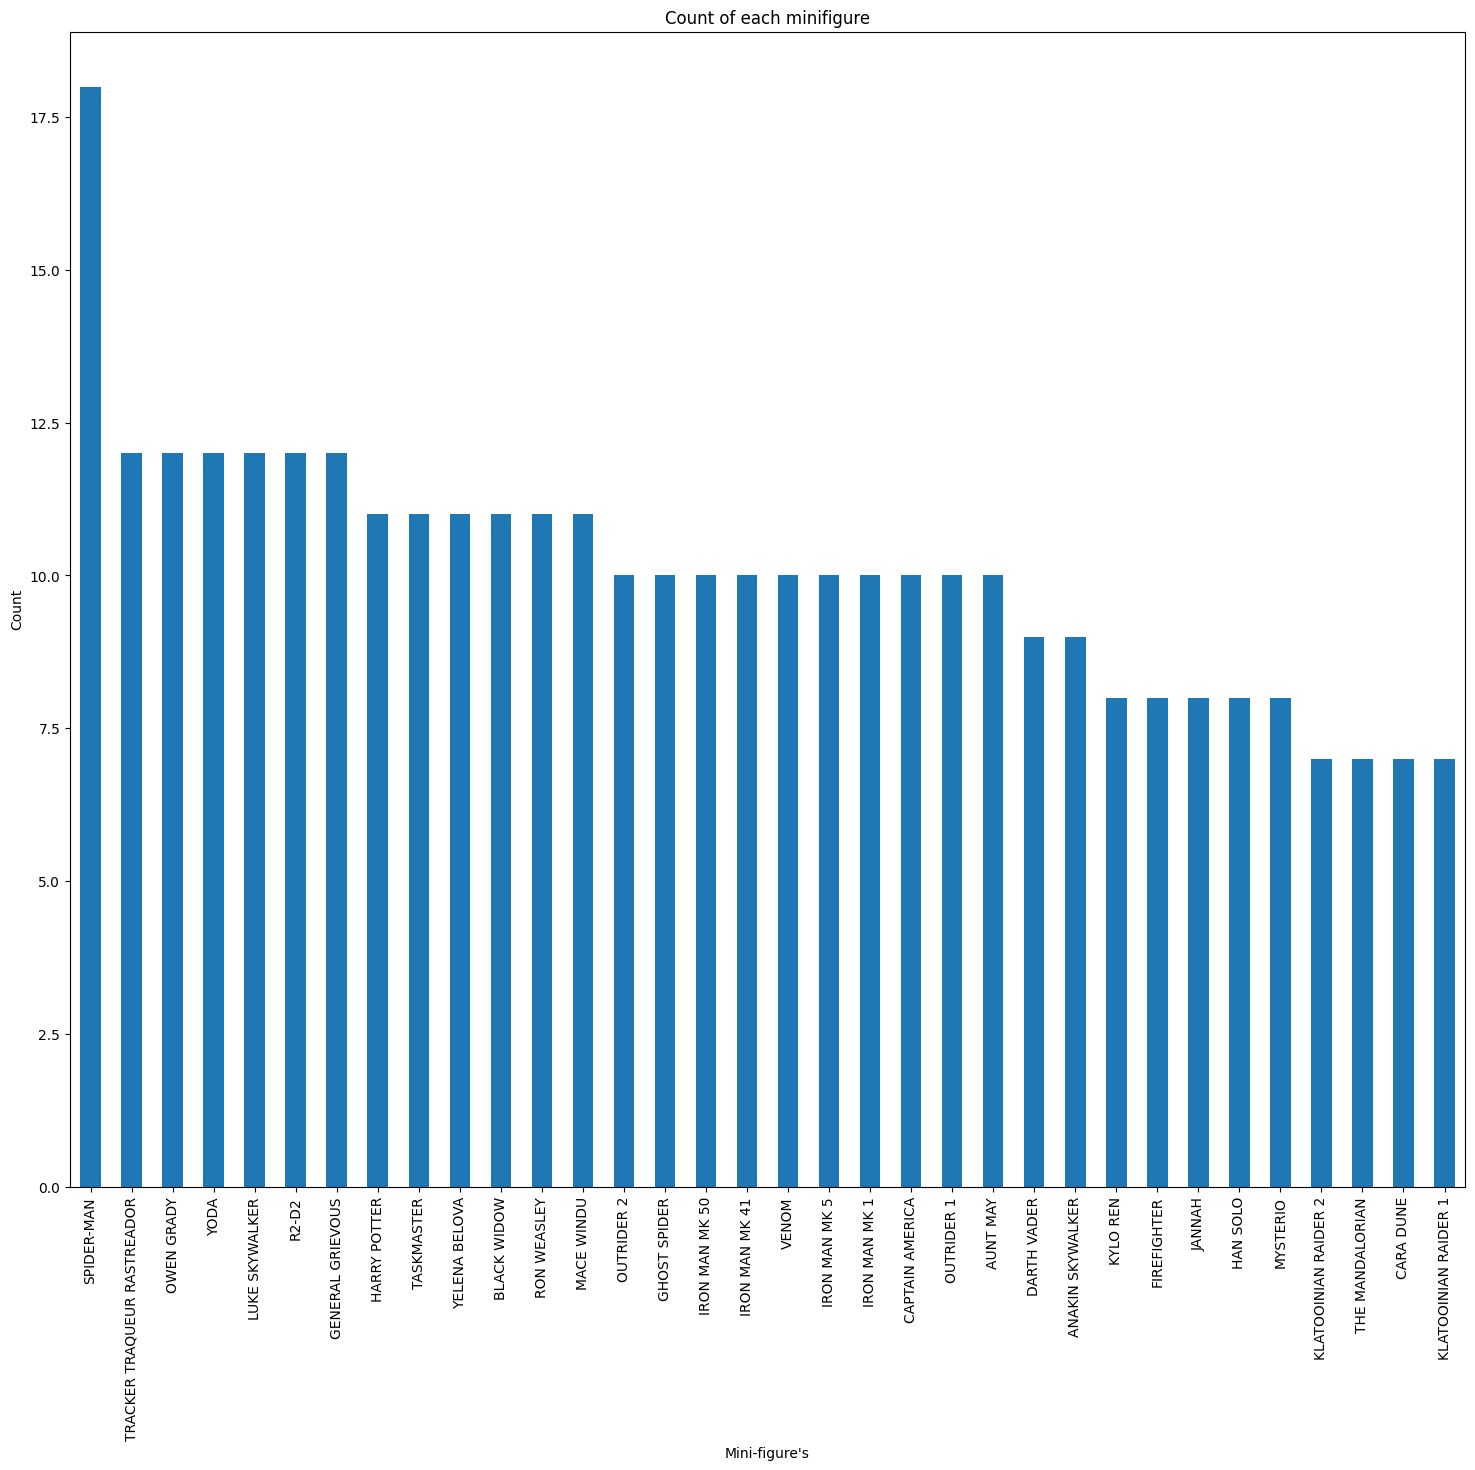

In [4]:
#Визуализация количества минифигурок каждого класса
ax0 = df['minifigure_name'].value_counts().plot(
    kind='bar',
    figsize = (18, 15),
    title='Count of each minifigure',
)
ax0.set_xlabel("Mini-figure's")
ax0.set_ylabel('Count')
plt.show()

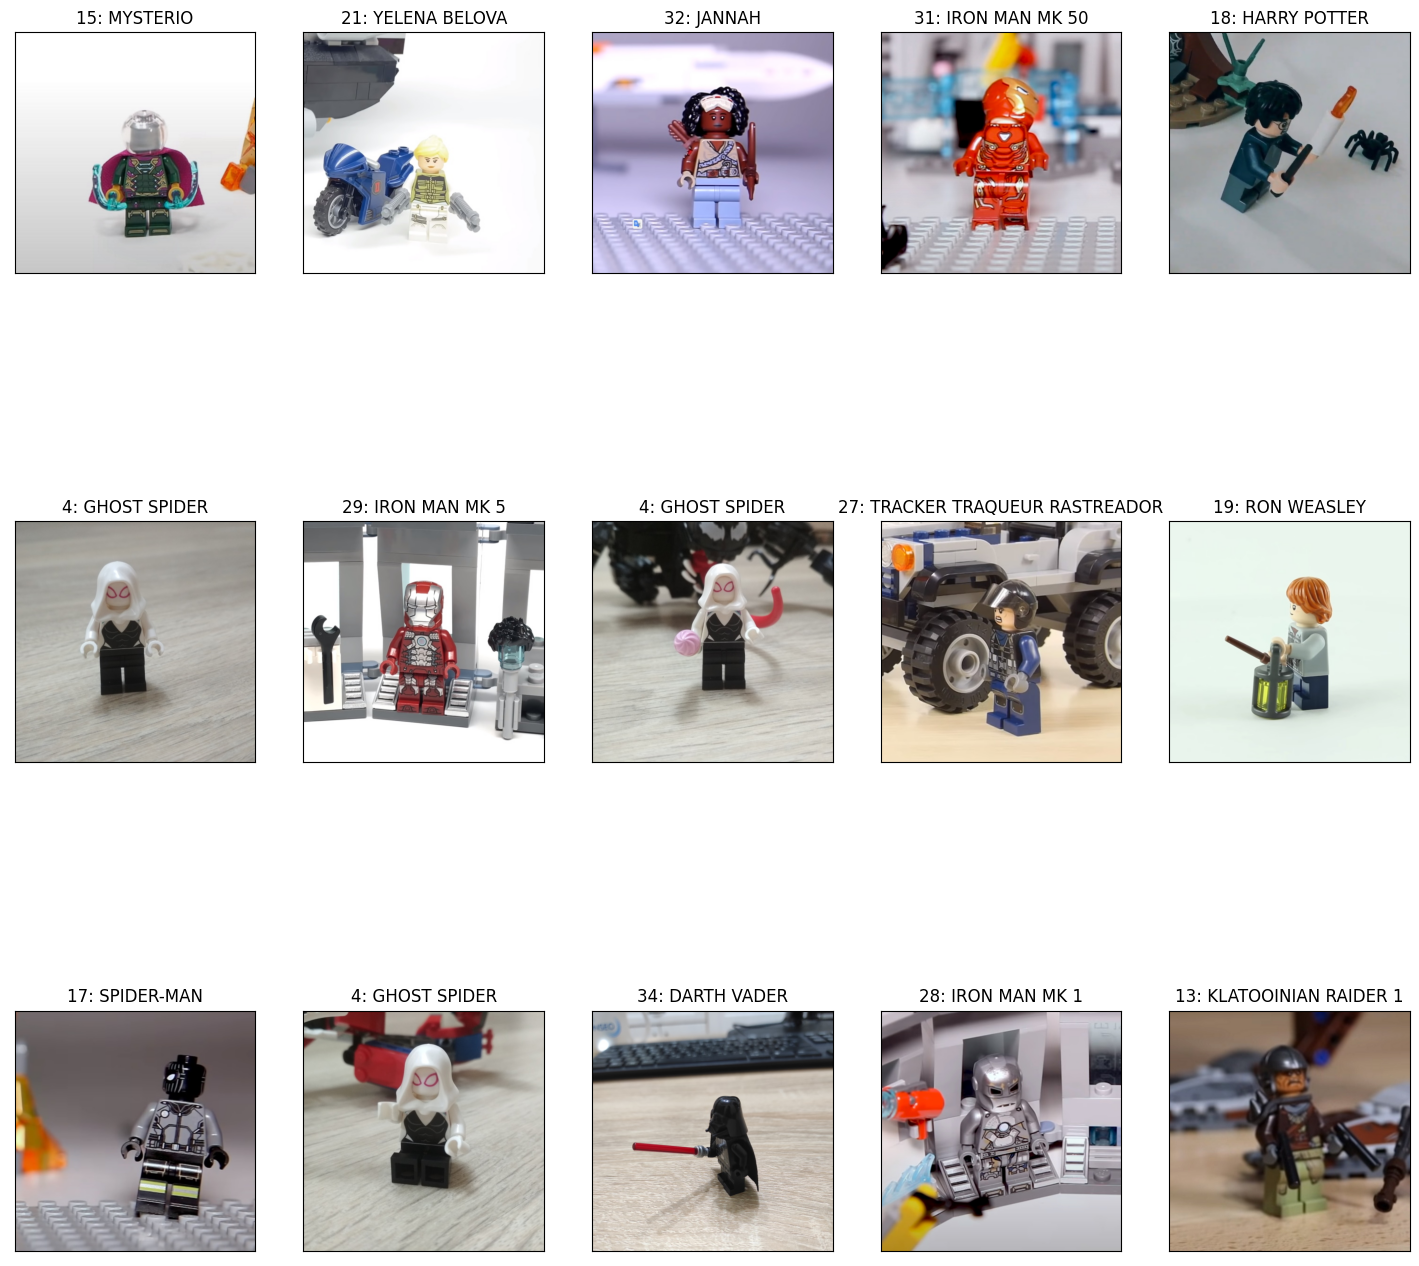

In [5]:
#Визуализация примеров для всех классов
plt1 = plt.figure(figsize=(18, 18))
for x,y in enumerate(df.sample(15).iterrows(), 1):
    plt.subplot(3, 5, x)
    image = cv2.imread(os.path.join(dataset_path, y[1]['path']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"{y[1]['class_id']}: {y[1]['minifigure_name']}")
    plt.xticks([])
    plt.yticks([])

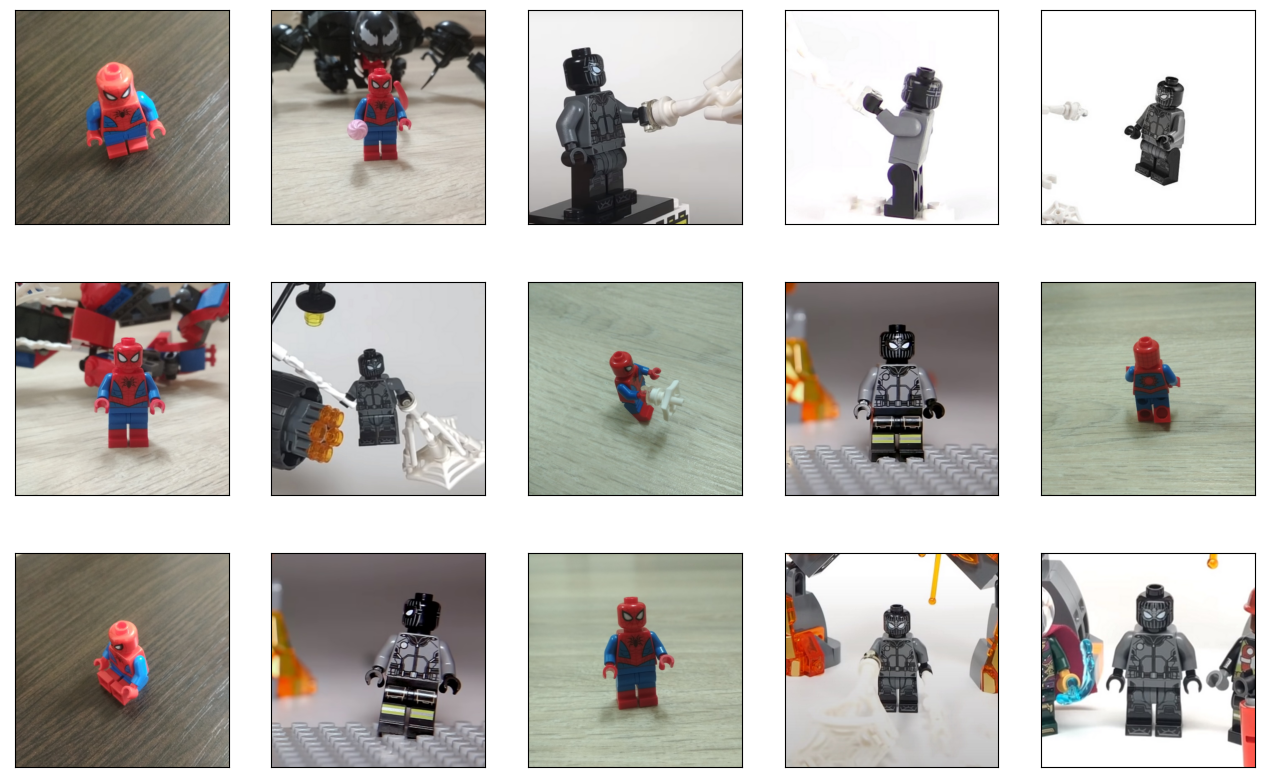

In [6]:
#Визуализация примеров для класса 'Spider-man'
plt2 = plt.figure(figsize=(16, 10))
for x, y in enumerate(df[df['minifigure_name']=='SPIDER-MAN'].sample(15).iterrows(), 1):
    plt.subplot(3, 5, x)
    image = cv2.imread(os.path.join(dataset_path, y[1]['path']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

In [15]:
#Подготовка данных
df_train = pd.DataFrame([])
df_valid = pd.DataFrame([])

for i in range(1, len(df['class_id'].value_counts()) + 1):
    df_train = pd.concat([df_train, df[df['class_id'] == i].iloc[:-1]], ignore_index=True)
    df_valid = pd.concat([df_valid, df[df['class_id'] == i].iloc[-1:]], ignore_index=True)
    

In [16]:
#Инициализация и настройка DenseNet
base_model = tf.keras.applications.DenseNet121()
my_layer = Dropout(0.5)(base_model.layers[-2].output)
number_of_classes = len(df['class_id'].unique())
my_outputs = Dense(number_of_classes, activation="softmax")(my_layer)
model = Model(base_model.input, my_outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

33188688/33188688 [==============================] - 11s 0us/step


In [18]:
#Преобразование данных
X_train = np.zeros((df_train.shape[0], 224, 224, 3))
for i in range(df_train.shape[0]):
    image = cv2.imread('../DataSets/lego_minifigures/' + df_train["path"].values[i])
    image = cv2.resize(image, dsize=(224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_train[i] = image/255
Y_train = np.array(df_train["class_id"])-1
X_valid = np.zeros((df_valid.shape[0], 224, 224, 3))

for i in range(df_valid.shape[0]):
    image = cv2.imread('../DataSets/lego_minifigures/' + df_valid["path"].values[i])
    image = cv2.resize(image, dsize=(224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_valid[i] = image/255
Y_valid = np.array(df_valid["class_id"])-1

In [20]:
checkpoint = ModelCheckpoint(filepath='LEGO_MINI.h5', monitor="accuracy", save_best_only=True, verbose=1)
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid), shuffle=True,
          batch_size=4, callbacks=checkpoint)

Epoch 1/10
77/77 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9805
Epoch 1: accuracy improved from -inf to 0.98046, saving model to LEGO_MINI.h5
77/77 [==============================] - 54s 704ms/step - loss: 0.1474 - accuracy: 0.9805 - val_loss: 0.1104 - val_accuracy: 1.0000
Epoch 2/10
77/77 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9935
Epoch 2: accuracy improved from 0.98046 to 0.99349, saving model to LEGO_MINI.h5
77/77 [==============================] - 74s 958ms/step - loss: 0.1283 - accuracy: 0.9935 - val_loss: 0.1059 - val_accuracy: 1.0000
Epoch 3/10
77/77 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9935
Epoch 3: accuracy did not improve from 0.99349
77/77 [==============================] - 82s 1s/step - loss: 0.1093 - accuracy: 0.9935 - val_loss: 0.0892 - val_accuracy: 0.9714
Epoch 4/10
77/77 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9967
Epoch 4: accuracy improve

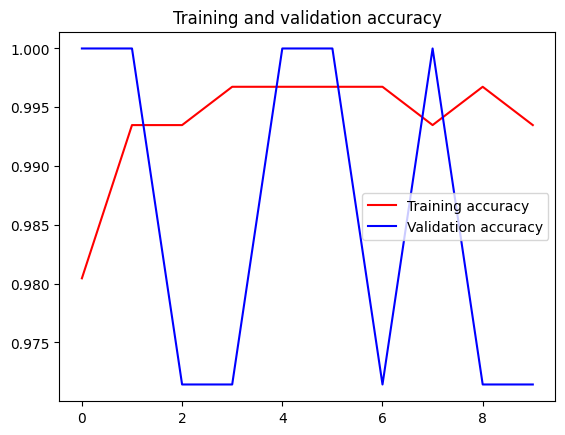

<Figure size 640x480 with 0 Axes>

In [21]:
#Training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()


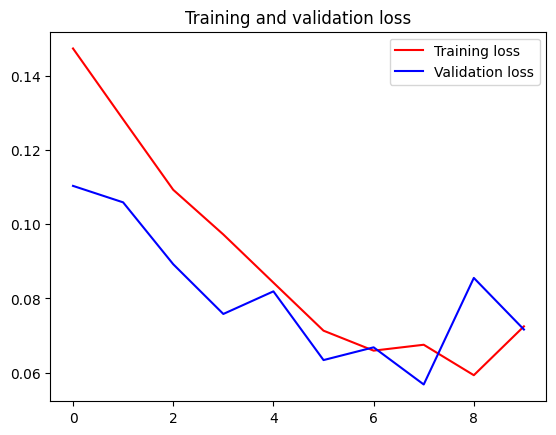

<Figure size 640x480 with 0 Axes>

In [22]:
#Training and validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()